In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from sklearn import neural_network
from skimage import io, color, transform, feature
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using BinaryClassificationPerformance v1.03


In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### file paths and names

In [3]:
ci_path = '../plane_data/cropped_images/' # file path for cropped images for training
l_file = '../plane_data/plane_labels.csv' # file path and file name for csv with labels

# Function for feature building and extraction on photographs¶

scikit-image documentation on methods used for feature extraction:  

* http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray  
* http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize  
* http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

In [4]:
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (60, 140) # used for downscale_local_mean

downscaled image shape: 
(10, 28)
image representation (first row of pixels): 
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


example of transformation: 


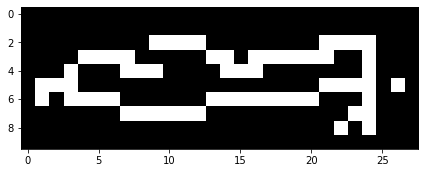

In [5]:
def image_manipulation(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    downscaled = transform.downscale_local_mean(img_raw, (6,5))
    
    final_image = feature.canny(downscaled) # edge filter image with Canny algorithm
    if imview==True:
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image

# test the function, look at input/output
test_image = image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

for comparison, look at original image:

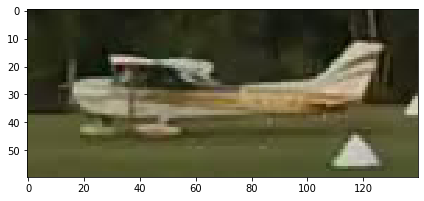

In [6]:
this_imname = ci_path + '2017-08-25T23+24+13_390Z.png'
io.imshow(io.imread(this_imname))

# function to process raw images, resulting in training and test datasets

In [7]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)


In [8]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=25, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)
Shape of original feature representation: 
(6758, 10, 28)
Shape of flat feature representation: 
(6758, 280)
Shape of Y: 
(6758,)
Number of images with planes: 
101
Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
67
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
34
Shape of data_train and data_test:
(5068, 280)
(1690, 280)
Shape of y_train and y_test:
(5068,)
(1690,)
Shape of imgs_train and imgs_test:
(5068,)
(1690,)
SUCCESS!


# Multilayer Perceptron, a.k.a. neural network

# ITERATIONS

##### Original value

In [10]:
# MODEL: Multi-layer Perceptron aka neural network

# # nn default:
nnd = neural_network.MLPClassifier(max_iter=1000)

print(nnd)
nnd.fit(data_train, y_train)

nnd_performance = BinaryClassificationPerformance(nnd.predict(data_train), y_train, 'nnd')
nnd_performance.compute_measures()
nnd_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nnd_performance.performance_measures)

nnd_performance_test = BinaryClassificationPerformance(nnd.predict(data_test), y_test, 'nnd_test')
nnd_performance_test.compute_measures()
nnd_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nnd_performance_test.performance_measures)

nnd_performance_test.img_indices()
nnd_img_indices_to_view = nnd_performance_test.image_indices


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 67, 'Neg': 5001, 'TP': 67, 'TN': 5001, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nnd', 'set': 'train'}
TEST SET: 
{'Pos': 34, 'Neg': 1656, 'TP': 16, 'TN': 1655, 'FP': 1, 'FN': 18, 'Accuracy': 0.9887573964497042, 'Precision': 0.9411764705882353, 'Recall': 0.47058823529411764, 'desc': 'nnd_test', 'set': 'test'}


### Iteration 1:

In [11]:
# MODEL: Multi-layer Perceptron aka neural network

# # nn (max_iter=1000, activation='logistic') as used in previous iteration, no hidden layers:
nn_1 = neural_network.MLPClassifier(max_iter=1000, activation='logistic')

print(nn_1)
nn_1.fit(data_train, y_train)

nn_1_performance = BinaryClassificationPerformance(nn_1.predict(data_train), y_train, 'nn-logistic')
nn_1_performance.compute_measures()
nn_1_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_1_performance.performance_measures)

nn_1_performance_test = BinaryClassificationPerformance(nn_1.predict(data_test), y_test, 'nn-logistic_test')
nn_1_performance_test.compute_measures()
nn_1_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_1_performance_test.performance_measures)

nn_1_performance_test.img_indices()
nn1_img_indices_to_view = nn_1_performance_test.image_indices


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 67, 'Neg': 5001, 'TP': 67, 'TN': 5001, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn-logistic', 'set': 'train'}
TEST SET: 
{'Pos': 34, 'Neg': 1656, 'TP': 16, 'TN': 1646, 'FP': 10, 'FN': 18, 'Accuracy': 0.9834319526627219, 'Precision': 0.6153846153846154, 'Recall': 0.47058823529411764, 'desc': 'nn-logistic_test', 'set': 'test'}


### Iteration 2:

In [12]:
# MODEL: Multi-layer Perceptron aka neural network

# # nn 2:
nn_2 = neural_network.MLPClassifier(max_iter=1000, activation='logistic', hidden_layer_sizes=(4, 3, 2))

print(nn_2)
nn_2.fit(data_train, y_train)

nn_2_performance = BinaryClassificationPerformance(nn_2.predict(data_train), y_train, 'nn4-3-2')
nn_2_performance.compute_measures()
nn_2_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_2_performance.performance_measures)

nn_2_performance_test = BinaryClassificationPerformance(nn_2.predict(data_test), y_test, 'nn4-3-2_test')
nn_2_performance_test.compute_measures()
nn_2_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_2_performance_test.performance_measures)

nn_2_performance_test.img_indices()
nn_2_img_indices_to_view = nn_2_performance_test.image_indices


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(4, 3, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 67, 'Neg': 5001, 'TP': 0, 'TN': 5001, 'FP': 0, 'FN': 67, 'Accuracy': 0.9867797947908445, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn4-3-2', 'set': 'train'}
TEST SET: 
{'Pos': 34, 'Neg': 1656, 'TP': 0, 'TN': 1656, 'FP': 0, 'FN': 34, 'Accuracy': 0.9798816568047337, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn4-3-2_test', 'set': 'test'}


/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/machine-learning/final_assignment_02/iteration_02/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/machine-learning/final_assignment_02/iteration_02/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### Iteration 3:

In [13]:
# MODEL: Multi-layer Perceptron aka neural network

# # nn 3:
nn_3 = neural_network.MLPClassifier(max_iter=1000, activation='logistic', hidden_layer_sizes=(50,25,15))

print(nn_3)
nn_3.fit(data_train, y_train)

nn_3_performance = BinaryClassificationPerformance(nn_3.predict(data_train), y_train, 'nn50-25-15')
nn_3_performance.compute_measures()
nn_3_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_3_performance.performance_measures)

nn_3_performance_test = BinaryClassificationPerformance(nn_3.predict(data_test), y_test, 'nn50_25_15_test')
nn_3_performance_test.compute_measures()
nn_3_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_3_performance_test.performance_measures)

nn_3_performance_test.img_indices()
nn_3_img_indices_to_view = nn_3_performance_test.image_indices


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 25, 15), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 67, 'Neg': 5001, 'TP': 0, 'TN': 5001, 'FP': 0, 'FN': 67, 'Accuracy': 0.9867797947908445, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn50-25-15', 'set': 'train'}
TEST SET: 
{'Pos': 34, 'Neg': 1656, 'TP': 0, 'TN': 1656, 'FP': 0, 'FN': 34, 'Accuracy': 0.9798816568047337, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn50_25_15_test', 'set': 'test'}


/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/machine-learning/final_assignment_02/iteration_02/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/machine-learning/final_assignment_02/iteration_02/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### Iteration 4

In [14]:
# MODEL: Multi-layer Perceptron aka neural network

# # nn 4:
nn_4 = neural_network.MLPClassifier(max_iter=1000, activation='logistic', hidden_layer_sizes=(6,5,4,3))

print(nn_4)
nn_4.fit(data_train, y_train)

nn_4_performance = BinaryClassificationPerformance(nn_4.predict(data_train), y_train, 'nn6-5-4-3')
nn_4_performance.compute_measures()
nn_4_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_4_performance.performance_measures)

nn_4_performance_test = BinaryClassificationPerformance(nn_4.predict(data_test), y_test, 'nn6-5-4-3_test')
nn_4_performance_test.compute_measures()
nn_4_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_4_performance_test.performance_measures)

nn_4_performance_test.img_indices()
nn_4_img_indices_to_view = nn_4_performance_test.image_indices


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 5, 4, 3), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 67, 'Neg': 5001, 'TP': 0, 'TN': 5001, 'FP': 0, 'FN': 67, 'Accuracy': 0.9867797947908445, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn6-5-4-3', 'set': 'train'}
TEST SET: 
{'Pos': 34, 'Neg': 1656, 'TP': 0, 'TN': 1656, 'FP': 0, 'FN': 34, 'Accuracy': 0.9798816568047337, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn6-5-4-3_test', 'set': 'test'}


/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/machine-learning/final_assignment_02/iteration_02/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/machine-learning/final_assignment_02/iteration_02/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### Iteration 5

In [15]:
# MODEL: Multi-layer Perceptron aka neural network

# # nn 5:
nn_5 = neural_network.MLPClassifier(max_iter=1000, activation='logistic', hidden_layer_sizes=(100, 80, 60, 40, 20))

print(nn_5)
nn_5.fit(data_train, y_train)

nn_5_performance = BinaryClassificationPerformance(nn_5.predict(data_train), y_train, 'nn-100-80-60-40-20')
nn_5_performance.compute_measures()
nn_5_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_5_performance.performance_measures)

nn_5_performance_test = BinaryClassificationPerformance(nn_5.predict(data_test), y_test, 'nn-100-80-60-40-20_test')
nn_5_performance_test.compute_measures()
nn_5_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_5_performance_test.performance_measures)

nn_5_performance_test.img_indices()
nn_5_img_indices_to_view = nn_5_performance_test.image_indices


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 80, 60, 40, 20),
              learning_rate='constant', learning_rate_init=0.001, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
TRAINING SET: 
{'Pos': 67, 'Neg': 5001, 'TP': 0, 'TN': 5001, 'FP': 0, 'FN': 67, 'Accuracy': 0.9867797947908445, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn-100-80-60-40-20', 'set': 'train'}
TEST SET: 
{'Pos': 34, 'Neg': 1656, 'TP': 0, 'TN': 1656, 'FP': 0, 'FN': 34, 'Accuracy': 0.9798816568047337, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn-100-80-60-40-20_test', 'set': 'test'}


/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/machine-learning/final_assignment_02/iteration_02/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/machine-learning/final_assignment_02/iteration_02/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### Iteration 6

In [16]:
# MODEL: Multi-layer Perceptron aka neural network

# # nn 6:
nn_6 = neural_network.MLPClassifier(max_iter=1000, activation='logistic', hidden_layer_sizes=(200, ))

print(nn_6)
nn_6.fit(data_train, y_train)

nn_6_performance = BinaryClassificationPerformance(nn_6.predict(data_train), y_train, 'nn-32-16-4')
nn_6_performance.compute_measures()
nn_6_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_6_performance.performance_measures)

nn_6_performance_test = BinaryClassificationPerformance(nn_6.predict(data_test), y_test, 'nn-32-16-4_test')
nn_6_performance_test.compute_measures()
nn_6_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_6_performance_test.performance_measures)

nn_6_performance_test.img_indices()
nn_6_img_indices_to_view = nn_6_performance_test.image_indices


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 67, 'Neg': 5001, 'TP': 67, 'TN': 5001, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn-32-16-4', 'set': 'train'}
TEST SET: 
{'Pos': 34, 'Neg': 1656, 'TP': 18, 'TN': 1644, 'FP': 12, 'FN': 16, 'Accuracy': 0.9834319526627219, 'Precision': 0.6, 'Recall': 0.5294117647058824, 'desc': 'nn-32-16-4_test', 'set': 'test'}


### Iteration 7

In [17]:
# MODEL: Multi-layer Perceptron aka neural network

# # nn 7:
nn_7 = neural_network.MLPClassifier(max_iter=1000, activation='logistic', hidden_layer_sizes=(32, 16, 4))

print(nn_7)
nn_7.fit(data_train, y_train)

nn_7_performance = BinaryClassificationPerformance(nn_7.predict(data_train), y_train, 'nn-32-16-4')
nn_7_performance.compute_measures()
nn_7_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_7_performance.performance_measures)

nn_7_performance_test = BinaryClassificationPerformance(nn_7.predict(data_test), y_test, 'nn-32-16-4_test')
nn_7_performance_test.compute_measures()
nn_7_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_7_performance_test.performance_measures)

nn_7_performance_test.img_indices()
nn_7_img_indices_to_view = nn_7_performance_test.image_indices


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 16, 4), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 67, 'Neg': 5001, 'TP': 0, 'TN': 5001, 'FP': 0, 'FN': 67, 'Accuracy': 0.9867797947908445, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn-32-16-4', 'set': 'train'}
TEST SET: 
{'Pos': 34, 'Neg': 1656, 'TP': 0, 'TN': 1656, 'FP': 0, 'FN': 34, 'Accuracy': 0.9798816568047337, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn-32-16-4_test', 'set': 'test'}


/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/machine-learning/final_assignment_02/iteration_02/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/machine-learning/final_assignment_02/iteration_02/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### Iteration 8

In [18]:
# MODEL: Multi-layer Perceptron aka neural network

# # nn 8:
nn_8 = neural_network.MLPClassifier(max_iter=1000, activation='logistic', hidden_layer_sizes=(256, 256))

print(nn_8)
nn_8.fit(data_train, y_train)

nn_8_performance = BinaryClassificationPerformance(nn_8.predict(data_train), y_train, 'nn-256-256')
nn_8_performance.compute_measures()
nn_8_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_8_performance.performance_measures)

nn_8_performance_test = BinaryClassificationPerformance(nn_8.predict(data_test), y_test, 'nn-256-256_test')
nn_8_performance_test.compute_measures()
nn_8_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_8_performance_test.performance_measures)

nn_8_performance_test.img_indices()
nn_8_img_indices_to_view = nn_8_performance_test.image_indices


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(256, 256), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 67, 'Neg': 5001, 'TP': 67, 'TN': 5001, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn-256-256', 'set': 'train'}
TEST SET: 
{'Pos': 34, 'Neg': 1656, 'TP': 18, 'TN': 1647, 'FP': 9, 'FN': 16, 'Accuracy': 0.985207100591716, 'Precision': 0.6666666666666666, 'Recall': 0.5294117647058824, 'desc': 'nn-256-256_test', 'set': 'test'}


### cache fits

In [20]:
fits = [nnd_performance, nn_1_performance, nn_2_performance, nn_3_performance, nn_4_performance,
        nn_5_performance, nn_6_performance, nn_7_performance, nn_8_performance,
       nnd_performance_test, nn_1_performance_test, nn_2_performance_test, nn_3_performance_test,
        nn_4_performance_test, nn_5_performance_test, nn_6_performance_test, nn_7_performance_test, 
        nn_8_performance_test]

# comparisons

In [21]:
# list of fits to compare: 
final_fits = []

for fit in fits:
    final_fits.append(fit.performance_measures)
#     final_fits.append(nn_performance_test.performance_measures)

In [22]:
final_fits

[{'Pos': 67,
  'Neg': 5001,
  'TP': 67,
  'TN': 5001,
  'FP': 0,
  'FN': 0,
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'desc': 'nnd',
  'set': 'train'},
 {'Pos': 67,
  'Neg': 5001,
  'TP': 67,
  'TN': 5001,
  'FP': 0,
  'FN': 0,
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'desc': 'nn-logistic',
  'set': 'train'},
 {'Pos': 67,
  'Neg': 5001,
  'TP': 0,
  'TN': 5001,
  'FP': 0,
  'FN': 67,
  'Accuracy': 0.9867797947908445,
  'Precision': nan,
  'Recall': 0.0,
  'desc': 'nn4-3-2',
  'set': 'train'},
 {'Pos': 67,
  'Neg': 5001,
  'TP': 0,
  'TN': 5001,
  'FP': 0,
  'FN': 67,
  'Accuracy': 0.9867797947908445,
  'Precision': nan,
  'Recall': 0.0,
  'desc': 'nn50-25-15',
  'set': 'train'},
 {'Pos': 67,
  'Neg': 5001,
  'TP': 0,
  'TN': 5001,
  'FP': 0,
  'FN': 67,
  'Accuracy': 0.9867797947908445,
  'Precision': nan,
  'Recall': 0.0,
  'desc': 'nn6-5-4-3',
  'set': 'train'},
 {'Pos': 67,
  'Neg': 5001,
  'TP': 0,
  'TN': 5001,
  'FP': 0,
  'FN': 67,
  'Accuracy': 

nnd: 
{'Pos': 67, 'Neg': 5001, 'TP': 67, 'TN': 5001, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nnd', 'set': 'train'}
nn-logistic: 
{'Pos': 67, 'Neg': 5001, 'TP': 67, 'TN': 5001, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn-logistic', 'set': 'train'}
nn4-3-2: 
{'Pos': 67, 'Neg': 5001, 'TP': 0, 'TN': 5001, 'FP': 0, 'FN': 67, 'Accuracy': 0.9867797947908445, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn4-3-2', 'set': 'train'}
nn50-25-15: 
{'Pos': 67, 'Neg': 5001, 'TP': 0, 'TN': 5001, 'FP': 0, 'FN': 67, 'Accuracy': 0.9867797947908445, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn50-25-15', 'set': 'train'}
nn6-5-4-3: 
{'Pos': 67, 'Neg': 5001, 'TP': 0, 'TN': 5001, 'FP': 0, 'FN': 67, 'Accuracy': 0.9867797947908445, 'Precision': nan, 'Recall': 0.0, 'desc': 'nn6-5-4-3', 'set': 'train'}
nn-100-80-60-40-20: 
{'Pos': 67, 'Neg': 5001, 'TP': 0, 'TN': 5001, 'FP': 0, 'FN': 67, 'Accuracy': 0.9867797947908445, 'Precision': nan, 'Recall':

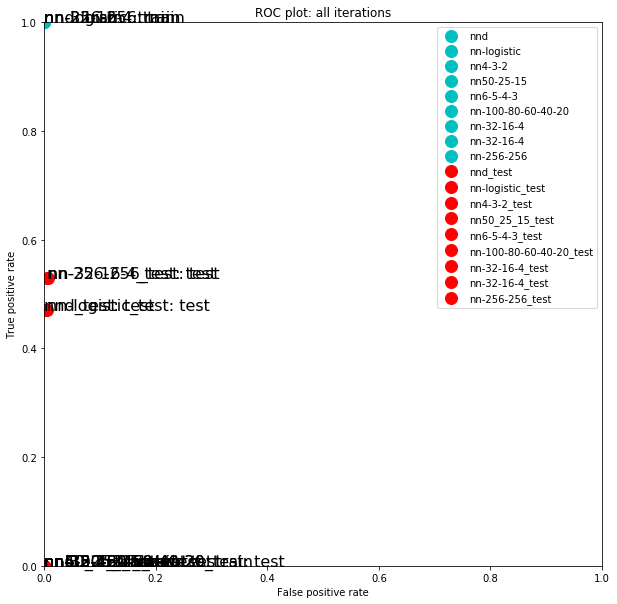

In [23]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
            
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12, label=fit['desc'])
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
    
    print(fit['desc'] + ': ')
    print(fit)

plt.axis([0, 1, 0, 1])
plt.title('ROC plot: all iterations')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

plt.show()


In [24]:
def plot_grouped_bars(measure, bar_limit=[0, 1]):
    # plots a grouped bar chart comparing training and test set
    # first argument represents the mesure to be compared - Accuracy and Precision plotted below
    # second argument defines whether the axes should be 0 to 1 or based on min and max values in the data
    accuracy_train = []
    accuracy_test = []
    description = []

    for fit in final_fits:
        print(fit['desc'])
        if fit['set'] == 'train':
            accuracy_train.append(fit[measure])
            description.append(fit['desc'])
        else:
            accuracy_test.append(fit[measure])

            
    width = 0.3
    x = np.arange(len(description))

    fig = plt.figure(figsize=[10, 3])
    ax = fig.add_axes([0,0,1,1])

    plt.grid()

    ax.bar(x, accuracy_train, color='b', width=width, label="training")
    ax.bar(x + width, accuracy_test, color='g', width=width, label="test")

    ax.set_ylabel(measure)
    ax.set_xlabel('hidden_layers')

    ax.set_title('MLPClassifier Training VS Test set performance - ' + measure)

    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(description)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    # make axes 0 to 1
    ax.set_ylim(bottom=bar_limit[0])
    ax.set_ylim(top=bar_limit[1])

    title = 'train_test_bars'

    # image_path = 'plot_images/03/' + title + '.png'
    # fig.savefig(image_path, dpi=fig.dpi)

    plt.show()

nnd
nn-logistic
nn4-3-2
nn50-25-15
nn6-5-4-3
nn-100-80-60-40-20
nn-32-16-4
nn-32-16-4
nn-256-256
nnd_test
nn-logistic_test
nn4-3-2_test
nn50_25_15_test
nn6-5-4-3_test
nn-100-80-60-40-20_test
nn-32-16-4_test
nn-32-16-4_test
nn-256-256_test


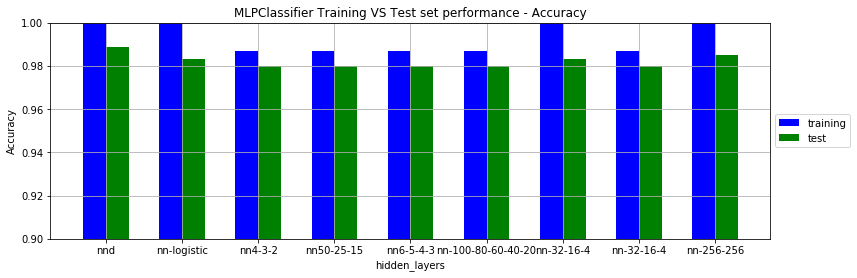

In [25]:
plot_grouped_bars("Accuracy", [0.9, 1])

nnd
nn-logistic
nn4-3-2
nn50-25-15
nn6-5-4-3
nn-100-80-60-40-20
nn-32-16-4
nn-32-16-4
nn-256-256
nnd_test
nn-logistic_test
nn4-3-2_test
nn50_25_15_test
nn6-5-4-3_test
nn-100-80-60-40-20_test
nn-32-16-4_test
nn-32-16-4_test
nn-256-256_test


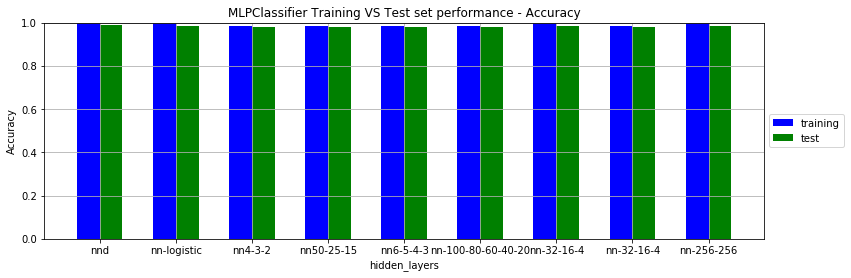

In [26]:
plot_grouped_bars("Accuracy")

nnd
nn-logistic
nn4-3-2
nn50-25-15
nn6-5-4-3
nn-100-80-60-40-20
nn-32-16-4
nn-32-16-4
nn-256-256
nnd_test
nn-logistic_test
nn4-3-2_test
nn50_25_15_test
nn6-5-4-3_test
nn-100-80-60-40-20_test
nn-32-16-4_test
nn-32-16-4_test
nn-256-256_test


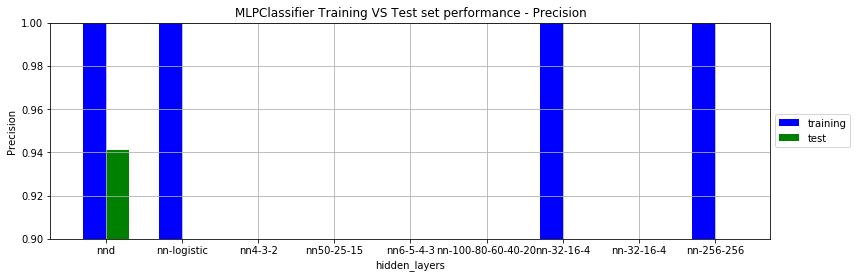

In [27]:
plot_grouped_bars("Precision", [0.9, 1])

nnd
nn-logistic
nn4-3-2
nn50-25-15
nn6-5-4-3
nn-100-80-60-40-20
nn-32-16-4
nn-32-16-4
nn-256-256
nnd_test
nn-logistic_test
nn4-3-2_test
nn50_25_15_test
nn6-5-4-3_test
nn-100-80-60-40-20_test
nn-32-16-4_test
nn-32-16-4_test
nn-256-256_test


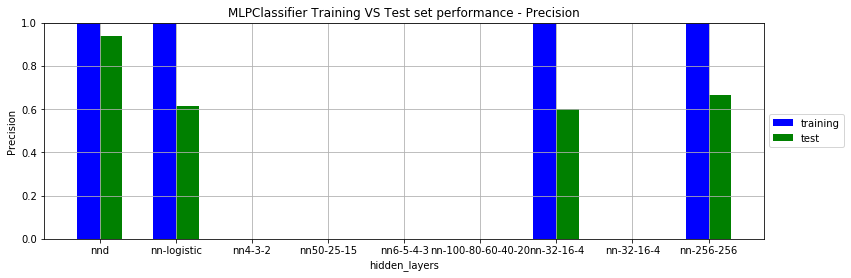

In [28]:
plot_grouped_bars("Precision")